In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, RDKitMinimalLib, GLM, Statistics, Plots, PyCall

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [3]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [4]:
species_to_exclude_cis = ["cis-2-heptene", "(z)-1,1,1,4,4,4-hexafluorobut-2-ene", "cis-1,2-dichloroethylene",
"cis-4-octene", "(1r,2s,5r)-(-)-2-isopropyl-5-methyl-cyclohexanol", "cis-3-methyl-2-pentene", 
"cis-1,2-dimethylcyclohexane", "crotonaldehyde", ".beta.-pinene", "tricyclo[5.2.1.0(2,6)]decane",
"cis-4,4-dimethyl-2-pentene", "cis-1,2-dimethylcyclopentane", "cis-2-octene", "2-pentene", "cis-1,3-dimethyl cyclohexane",
"cis-octahydro-1h-indene", "cis-1,3-dimethylcyclopentane", "cis-1,3-dichloropropene", "cis-3-heptene",
"cis-2-decene", "d-(+)-limonene", "limonene", "cis-2,2-dimethyl-3-hexene", "cis-1,3-pentadiene", 
"(z)-1,3,3,3-tetrafluoroprop-1-ene", ".alpha.-pinene", "d-.alpha.-pinene", "cis-1,4-dimethyl cyclohexane",
"cis-decahydronaphthalene", "decalin", "cis-3-methylcyclohexanol"]

species_to_exclude_trans = ["trans-2-heptene", "(e)-1,1,1,4,4,4-hexafluorobut-2-ene", "trans-1,2-dichloroethene",
"trans-4-octene", "dl-(1r,2s,5r)-rel-5-methyl-2-(1-methylethyl)cyclohexanol", "trans-3-methyl-2-pentene", 
"trans-1,2-dimethylcyclohexane", "trans-crotonaldehyde", "(-)-beta-pinene", "exo-tricyclo[5.2.1.0(2,6)]decane",
"trans-4,4-dimethyl-2-pentene", "trans-1,2-dimethylcyclopentane", "trans-2-octene", "trans-2-pentene",
"trans-1,3-dimethyl cyclohexane", "trans-octahydro-1h-indene", "trans-1,3-dimethylcyclopentane",
"trans-1,3-dichloropropene", "trans-3-heptene", "trans-2-decene", "l-(-)-limonene", "trans-2,2-dimethyl-3-hexene",
"trans-1,3-pentadiene", "(e)-1,3,3,3-tetrafluoroprop-1-ene", "l-.alpha.-pinene", "trans-1,4-dimethylcyclohexane",
"trans-decahydronaphthalene", "trans-3-methylcyclohexanol"]

# append!(species_to_exclude_cis,species_to_exclude_trans)

pcp_source_params_isomers_removed = filter(row -> !(row.common_name in species_to_exclude_cis), pcp_source_params);


In [5]:
chemical_family = "Alkanes"

if lowercase(chemical_family) == "linear alkanes"
    contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
    processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), pcp_source_params_isomers_removed) 
    processed_data = sort(processed_data_lin_alkanes, :Mw)
else
    if lowercase(chemical_family) == "all species"
        processed_data = pcp_source_params_isomers_removed
    else
        processed_data = filter(row -> lowercase(row.family) == lowercase(chemical_family), pcp_source_params_isomers_removed) 
        processed_data = sort(processed_data, :Mw)
    end
end

processed_data = sort(processed_data, :family)


processed_data.isomeric_SMILES;
# println(processed_data);
# processed_data

In [ ]:
isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints = []

for i in isomeric_smiles
    fingerprint_spec_i = []

    mol = get_mol(i)

    # fp_str1 = get_topological_torsion_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str1 = get_morgan_fp(mol, Dict{String,Any}("radius"=> 1, "nBits" => 2))
    # fp_str1 = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str2 = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))


    fp_str = fp_str1 #* fp_str2
    
    append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

    relevant_desc = [desc[k] for k in relevant_keys]
    # append!(fingerprint_spec_i, relevant_desc)
    append!(fingerprints, [fingerprint_spec_i])

end

# println(length(fingerprints[1]))

In [ ]:
# Remove repeated columns
for num = [0, 1]
    num_cols = length(fingerprints[1])
    zero_cols = trues(num_cols)
    for vec in fingerprints
        zero_cols .&= (vec .== num)
    end
    keep_cols = .!zero_cols # Create a Mask
    fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
end

println(length(fingerprints[1]))

2


In [6]:
# function count_repeated_vectors(arr)
#     vector_counts = Dict{Tuple, Int}()

#     for vector in arr
#         tuple_vector = Tuple(vector)

#         if haskey(vector_counts, tuple_vector)
#             vector_counts[tuple_vector] += 1
#         else
#             vector_counts[tuple_vector] = 1
#         end
#     end

#     repeated_vectors = filter(kv -> kv[2] > 1, vector_counts)
#     return repeated_vectors
# end


function count_repeated_vectors(arr)
    vector_counts = Dict{Vector, Int}()

    for vector in arr
        if haskey(vector_counts, vector)
            vector_counts[vector] += 1
        else
            vector_counts[vector] = 1
        end
    end

    repeated_vectors = filter(kv -> kv[2] > 1, vector_counts)
    return repeated_vectors
end

function count_unique_vectors(arr)
    vector_counts = Dict{Vector, Int}()

    for vector in arr
        if haskey(vector_counts, vector)
            vector_counts[vector] += 1
        else
            vector_counts[vector] = 1
        end
    end

    unique_vectors = filter(kv -> kv[2] > 0, vector_counts)
    return unique_vectors
end

function compare_fingerprints(vectors::Vector{Vector{T}}) where T
    n = length(vectors)
    jaccard_matrix = ones(Float64, n, n)
    total_differences = 0
    differences = []
    jaccard_coefficients = []
    counts = Dict{Int, Int}()

    for i in 1:n
        for j in i+1:n
            # Count the number of differing elements
            diff_count = sum(vectors[i] .!= vectors[j])

            # Count the number of common elements
            common_count = length(vectors[i]) - diff_count

            # append dictionary tracking the number of pairs that differ by a given number of counts
            counts[diff_count] = get(counts, diff_count, 0) + 1
            push!(differences, diff_count)

            # append variable tracking the total number of differences over all pairs
            total_differences += diff_count

            # compute the jaccard coefficient and push
            jaccard_coefficient = common_count / (length(vectors[i]) + length(vectors[j]) - common_count)
            push!(jaccard_coefficients, jaccard_coefficient)

            # store the coefficient in the matrix symmetrically
            jaccard_matrix[i, j] = jaccard_coefficient
            jaccard_matrix[j, i] = jaccard_coefficient
        end
    end
    average_diff = total_differences / (n * (n - 1) / 2)  # n choose 2
    average_jaccard = mean(jaccard_coefficients)
    # std_diff = std(differences)
    return counts, average_diff, average_jaccard, jaccard_matrix
end;

function find_interval_indices(value, intervals)
    for (i, interval) in enumerate(intervals[1:end-1])
        if value >= interval && value < intervals[i+1]
            return i
        end
    end
    return length(intervals) - 1
end;

In [ ]:
# Fingerprint comparisons for a given chemical family
repeated_vectors = count_repeated_vectors(fingerprints)
number_repeated_strings = length(values(repeated_vectors))

for i in keys(repeated_vectors)
    # Use a list comprehension to find indices where the vector matches the target_key
    matching_indices = findall(vector -> vector == i, fingerprints)
    for i in  matching_indices
        println(processed_data[i,:common_name])
    end
end

@show number_repeated_strings
result_compare = compare_fingerprints(fingerprints)

propane
n-butane
2-methylbutane
pentane
2,2-dimethylpropane
hexane
2-methylpentane
3-methylpentane
2,2-dimethylbutane
2,4-dimethylpentane
heptane
2,2,3-trimethylbutane
2,3-dimethylpentane
3-methylhexane
2-methylhexane
2,2-dimethylpentane
3,3-dimethylpentane
3-ethylpentane
2,2,4-trimethylpentane
octane
3-methylheptane
2,4-dimethylhexane
4-methylheptane
3,4-dimethylhexane
2-methylheptane
2,2-dimethylhexane
2,5-dimethylhexane
2,3-dimethylhexane
2,2,3-trimethylpentane
3,3-dimethylhexane
2-methyl-3-ethyl-pentane
3-methyl-3-ethylpentane
2,3,3-trimethylpentane
3-ethylhexane
2,2,5-trimethylhexane
nonane
2-methyloctane
3,3-diethylpentane
2,4,4-trimethylhexane
2,2,3,4-tetramethylpentane
2,3,3,4-tetramethylpentane
2,2,3,3-tetramethylpentane
2,2,4,4-tetramethylpentane
2,3-dimethylheptane
decane
2,7-dimethyloctane
2,6-dimethyloctane
2,2,5,5-tetramethylhexane
n-undecane
2-methyldecane
3-methyldecane
2,3-dimethylnonane
dodecane
2-methylundecane
3-methylundecane
2,3-dimethyldecane
tridecane
2-methyldo

(Dict(0 => 2781, 2 => 4, 1 => 375), 0.12120253164556961, 0.9196202531645572, [1.0 0.0 … 0.3333333333333333 0.3333333333333333; 0.0 1.0 … 0.3333333333333333 0.3333333333333333; … ; 0.3333333333333333 0.3333333333333333 … 1.0 1.0; 0.3333333333333333 0.3333333333333333 … 1.0 1.0])

In [ ]:
function zero_out_lower_triangle(matrix)
    n = size(matrix, 1)
    for i in 2:n
        for j in 1:i-1
            matrix[i, j] = NaN
        end
    end
    return matrix
end;

0.3333333333333333


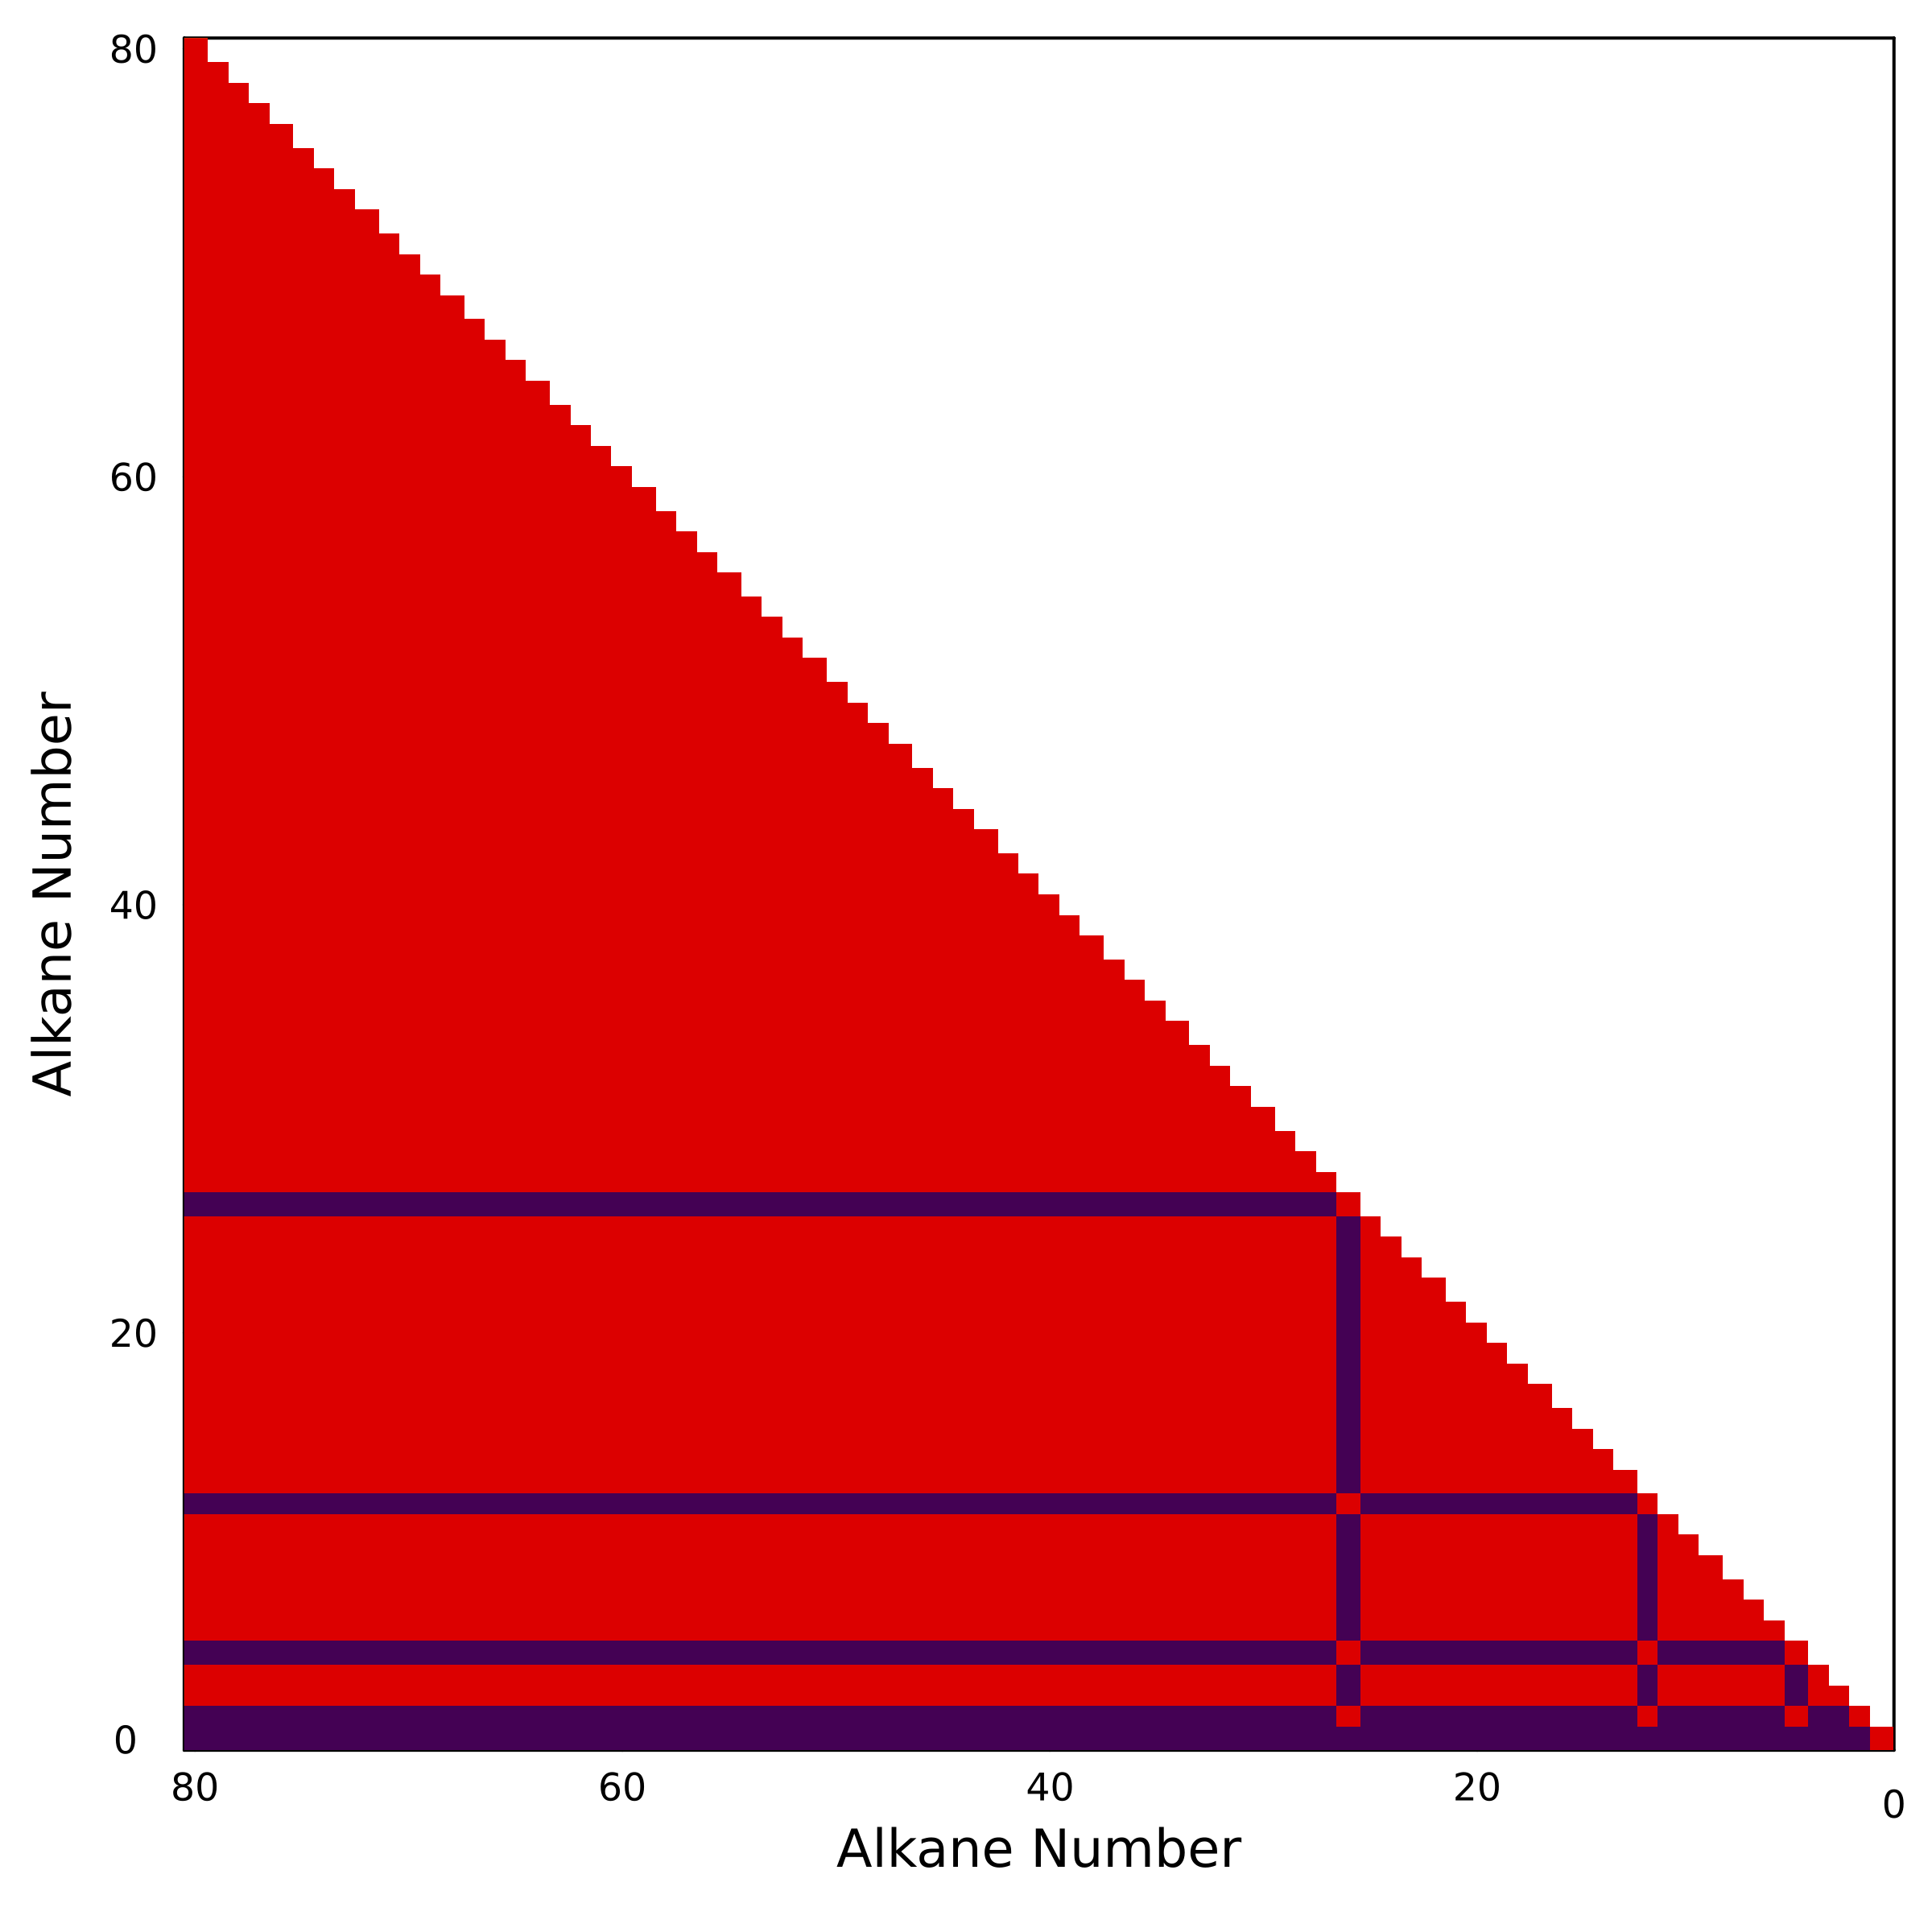

In [ ]:
# Extract the Jaccard coefficients from the result
jaccard_vector = result_compare[4]
clims = (0.5, 1)
axis_title = "Alkane Number"
# bound_upper = 1808.5
bound_upper = 80.5
size_ims = (600,600)

# Assuming the length of jaccard_vector is a perfect square
n = isqrt(length(jaccard_vector))

jaccard_matrix = reshape(jaccard_vector, (n, n))
min_value = minimum(jaccard_matrix[.!isnan.(jaccard_matrix) .& (jaccard_matrix .!= 0)])
println(min_value)

jaccard_matrix = zero_out_lower_triangle(jaccard_matrix)

updated_jaccard_matrix = copy(jaccard_matrix)
updated_jaccard_matrix[jaccard_matrix .!= 1] .= 0

# custom_map = [RGBA(1, 0, 0, 1), RGBA(0, 1, 0, 1), RGBA(0, 0, 1, 1), RGBA(0, 0, 0, 0)]
custom_map = cgrad([RGBA(220/255,0,0,0), RGBA(220/255,0,0,1)])

heatmap(jaccard_matrix,dpi=400,size = size_ims,c=:viridis, color=:viridis, xlims=(0, bound_upper),framestyle=:box,clims=clims,colorbar=true,xflip=true,grid=false,fontsize=12)
heatmap!(updated_jaccard_matrix, dpi=400, size = size_ims, c=custom_map, xlabel=axis_title, ylabel=axis_title,xlims=(0.5, bound_upper),framestyle=:box, clims=clims,colorbar=false,xflip=true,grid=false,fontsize=12)  # Set clims based on the first plot

# p_all = scatter!([NaN], [NaN], zcolor=[NaN], clims=clims, label="", c=:viridis, background_color_subplot=:transparent, markerstrokecolor=:transparent, framestyle=:none, inset=bbox(0.075, -0.04, 0.55, 0.85, :center, :right), subplot=2)

annotate!([(0.5, -2, text("0", 8, :DejaVuSans))])
annotate!([(83.25, 1, text("0", 8, :DejaVuSans))])
# annotate!([(-20, 40, text("Jaccard Coefficient", 12, :DejaVuSans, rotation=90))])
# annotate!([(-450, 900, text("Jaccard Coefficient", 12, :DejaVuSans, rotation=90))])

# plot!()  # Use plot!() to display the plot

# savefig("fingerprint_images/jaccard_comparison_alkane_pairs.svg");


In [11]:
n_pairs = collect(values(result_compare[1]))
total_count = sum(values(result_compare[1]))
proportion_pairs = n_pairs ./total_count

n_bits_different = collect(keys(result_compare[1]))
n_bits_different_sorted = sort(collect(keys(result_compare[1])))

cumulative_probabilities = cumsum([get(result_compare[1], v, 0) for v in n_bits_different_sorted]) / sum([get(result_compare[1], v, 0) for v in n_bits_different_sorted])

mean_bits_in_common_between_pairs = result_compare[2]
std_dev_bits_in_common_between_pairs = result_compare[3]

@show number_repeated_strings
@show mean_bits_in_common_between_pairs
@show std_dev_bits_in_common_between_pairs

# Calculate intervals of 10 for number of bits different
n_bits_interval = 1
n_bits_intervals = 0:n_bits_interval:maximum(n_bits_different_sorted) + n_bits_interval

# Group the data into intervals
interval_indices = [find_interval_indices(v, n_bits_intervals) for v in n_bits_different_sorted]

# Calculate aggregated values for each interval
aggregated_proportion_pairs = [sum(proportion_pairs[interval_indices .== i]) for i in 1:length(n_bits_intervals)-1]
interval_centers = (n_bits_intervals[1:end-1] + n_bits_intervals[2:end]) / 2

# Bar Chart
plt.figure(figsize=(8, 6), dpi=400)
plt.bar(interval_centers, aggregated_proportion_pairs * 100, width=n_bits_interval, edgecolor="black")
plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.ylim([0, 1])
plt.xlim([0, 100])

# ECDF
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(n_bits_different_sorted, cumulative_probabilities * 100, label="ECDF")
plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.ylim([0, 105])
plt.xlim([0, nothing]);


LoadError: UndefVarError: `result_compare` not defined

In [12]:
unique_values = unique(processed_data[!, :family])
num_rows = length(unique_values) + 1

# number repeated strings, repeated strings, 

processed_data = DataFrame(
    chemical_family = fill(missing, num_rows),
    rdkit_reps = fill(missing, num_rows),
    rdkit_rep_st = fill(missing,num_rows),
    inchi = fill(missing,num_rows),
    canonical_SMILES = fill(missing,num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    segment = fill(missing, num_rows),
    sigma = fill(missing, num_rows),
    epsilon = fill(missing, num_rows),
    dipole = fill(missing, num_rows),
    kappa_ab = fill(missing, num_rows),
    epsilon_k_ab = fill(missing, num_rows),
    na = fill(missing, num_rows),
    nb = fill(missing, num_rows),
    expt_p_sat_T_min = fill(missing, num_rows),
    expt_p_sat_T_max = fill(missing, num_rows),
    expt_density_T_min = fill(missing, num_rows),
    expt_density_T_max = fill(missing, num_rows),
    interaction = fill(missing,num_rows),
    bounds_violation = fill(missing,num_rows),
    source = fill(missing, num_rows)
) ;

LoadError: UndefVarError: `processed_data` not defined

In [13]:
# This plots the CFDs for mutliple fingerprints

n_bits_different_sorted_all_fp = []
cumulative_percentiles_all_fp = []
number_repeated_strings_all_fp = []
mean_bits_in_common_between_pairs_all_fp = []
std_dev_bits_in_common_between_pairs_all_fp = []

isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints_rdkit = []
fingerprints_morgan = []
fingerprints_pattern = []
fingerprints_atom_pair = []

fingerprints_rdkit_morgan = []
fingerprints_rdkit_pattern = []
fingerprints_rdkit_morgan_pattern = []

fingerprints_atom_pair_morgan = []
fingerprints_atom_pair_pattern = []
fingerprints_atom_pair_morgan_pattern = []

fingerprints_atom_pair_morgan_pattern_rdkit = []

for i in isomeric_smiles
    
    mol = get_mol(i)

    fingerprint_spec_i_rdkit = []
    fingerprint_spec_i_morgan = []
    fingerprint_spec_i_pattern = []
    fingerprint_spec_i_atom_pair = []

    fingerprint_spec_i_rdkit_morgan = []
    fingerprint_spec_i_rdkit_pattern = []
    fingerprint_spec_i_rdkit_morgan_pattern = []

    fingerprint_spec_i_atom_pair_morgan = []
    fingerprint_spec_i_atom_pair_pattern = []
    fingerprint_spec_i_atom_pair_morgan_pattern = []

    fingerprint_spec_i_atom_pair_morgan_pattern_rdkit = []

    fp_str_spec_i_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))

    fp_str_spec_i_rdkit_morgan = fp_str_spec_i_rdkit * fp_str_spec_i_morgan
    fp_str_spec_i_rdkit_pattern = fp_str_spec_i_rdkit * fp_str_spec_i_pattern
    fp_str_spec_i_rdkit_morgan_pattern = fp_str_spec_i_rdkit * fp_str_spec_i_morgan * fp_str_spec_i_pattern

    fp_str_spec_i_atom_pair_morgan = fp_str_spec_i_atom_pair * fp_str_spec_i_morgan
    fp_str_spec_i_atom_pair_pattern = fp_str_spec_i_atom_pair * fp_str_spec_i_pattern
    fp_str_spec_i_atom_pair_morgan_pattern = fp_str_spec_i_atom_pair * fp_str_spec_i_morgan * fp_str_spec_i_pattern

    fp_str_spec_i_atom_pair_morgan_pattern_rdkit = fp_str_spec_i_atom_pair * fp_str_spec_i_morgan * fp_str_spec_i_pattern * fp_str_spec_i_rdkit
    
    append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit])
    append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_morgan])
    append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_pattern])
    append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair])

    append!(fingerprint_spec_i_rdkit_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit_morgan])
    append!(fingerprint_spec_i_rdkit_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit_pattern])
    append!(fingerprint_spec_i_rdkit_morgan_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit_morgan_pattern])

    append!(fingerprint_spec_i_atom_pair_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_morgan])
    append!(fingerprint_spec_i_atom_pair_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_pattern])
    append!(fingerprint_spec_i_atom_pair_morgan_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_morgan_pattern])

    append!(fingerprint_spec_i_atom_pair_morgan_pattern_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_morgan_pattern_rdkit])

    # desc = get_descriptors(mol)
    # relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]
    # relevant_desc = [desc[k] for k in relevant_keys]
    # append!(fingerprint_spec_i, relevant_desc)

    append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
    append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
    append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
    append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])

    append!(fingerprints_rdkit_morgan, [fingerprint_spec_i_rdkit_morgan])
    append!(fingerprints_rdkit_pattern, [fingerprint_spec_i_rdkit_pattern])
    append!(fingerprints_rdkit_morgan_pattern, [fingerprint_spec_i_rdkit_morgan_pattern])

    append!(fingerprints_atom_pair_morgan, [fingerprint_spec_i_atom_pair_morgan])
    append!(fingerprints_atom_pair_pattern, [fingerprint_spec_i_atom_pair_pattern])
    append!(fingerprints_atom_pair_morgan_pattern, [fingerprint_spec_i_atom_pair_morgan_pattern])

    append!(fingerprints_atom_pair_morgan_pattern_rdkit, [fingerprint_spec_i_atom_pair_morgan_pattern_rdkit])

end

all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_pattern, fingerprints_atom_pair, 
fingerprints_rdkit_morgan, fingerprints_rdkit_pattern, fingerprints_rdkit_morgan_pattern, fingerprints_atom_pair_morgan,
fingerprints_atom_pair_pattern, fingerprints_atom_pair_morgan_pattern, fingerprints_atom_pair_morgan_pattern_rdkit]

for fingerprints in all_fingerprints
# Remove repeated columns
    for num = [0, 1]
        num_cols = length(fingerprints[1])
        zero_cols = trues(num_cols)
        for vec in fingerprints
            zero_cols .&= (vec .== num)
        end
        keep_cols = .!zero_cols # Create a Mask
        fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
    end

    # Fingerprint comparisons for a given chemical family
    repeated_vectors = count_repeated_vectors(fingerprints)
    number_repeated_strings = length(values(repeated_vectors))

    for i in keys(repeated_vectors)
        # Use a list comprehension to find indices where the vector matches the target_key
        matching_indices = findall(vector -> vector == i, fingerprints)
        for i in  matching_indices
            println(processed_data[i,:species]) # comment this in to print the names of repeated species
        end
    end

    result_compare = compare_fingerprints(fingerprints)

    n_pairs = collect(values(result_compare[1]))
    total_count = sum(values(result_compare[1]))
    proportion_pairs = n_pairs ./total_count

    n_bits_different = collect(keys(result_compare[1]))
    n_bits_different_sorted = sort(collect(keys(result_compare[1])))

    cumulative_probabilities = cumsum([get(result_compare[1], v, 0) for v in n_bits_different_sorted]) / sum([get(result_compare[1], v, 0) for v in n_bits_different_sorted])

    mean_bits_in_common_between_pairs = result_compare[2]
    std_dev_bits_in_common_between_pairs = result_compare[3]

    push!(number_repeated_strings_all_fp, number_repeated_strings)
    push!(mean_bits_in_common_between_pairs_all_fp, mean_bits_in_common_between_pairs)
    push!(std_dev_bits_in_common_between_pairs_all_fp, std_dev_bits_in_common_between_pairs)

    push!(n_bits_different_sorted_all_fp,n_bits_different_sorted)
    push!(cumulative_percentiles_all_fp,cumulative_probabilities*100)
    # ECDF

    @show number_repeated_strings
    
end

LoadError: UndefVarError: `processed_data` not defined

In [ ]:
num_rows = length(n_bits_different_sorted_all_fp)

ecdf_data = DataFrame(
    n_bits_different_sorted_all_fp = fill([0.0], num_rows),
    cumulative_percentiles_all_fp = fill([0.0], num_rows)
) ;

for i = 1:length(n_bits_different_sorted_all_fp)
    ecdf_data[i,:cumulative_percentiles_all_fp] = cumulative_percentiles_all_fp[i]
    ecdf_data[i,:n_bits_different_sorted_all_fp] = n_bits_different_sorted_all_fp[i]
end

CSV.write("ecdf_data_all_fp.csv", ecdf_data)


LoadError: UndefVarError: `n_bits_different_sorted_all_fp` not defined

In [ ]:
plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(n_bits_different_sorted_all_fp)
    plt.plot(n_bits_different_sorted_all_fp[i], cumulative_percentiles_all_fp[i], label="ECDF")
end

plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.legend(["rdkit","morgan","pattern","atom_pair","rdkit + morgan","rdkit + pattern","rdkit + morgan + pattern",
"atom_pair + morgan","atom_pair + pattern","atom_pair + morgan + pattern","atom_pair + rdkit + morgan + pattern"],loc = "lower right")
plt.ylim([0, 105])
plt.xlim([0, nothing]);

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(n_bits_different_sorted_all_fp)
    plt.plot(n_bits_different_sorted_all_fp[i] ./n_bits_different_sorted_all_fp[i][end], cumulative_percentiles_all_fp[i], label="ECDF")
end

plt.xlabel("Fraction Max. Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "lower right")

plt.ylim([0, 105])
plt.xlim([0, 1]);

# rd_kit,  atom_pair, topological_torsion, unable to distibguish between non-carbon-containing things, but pattern and morgan
# can => concatenate at least one from each of these sets

# rdkit
# atom_pair
# topological_torsion
# morgan
# pattern

# rdkit + morgan
# rdkit + pattern
# rdkit + atom_pair
# rdkit + topological_torsion
# atom_pair + morgan
# atom_pair + pattern # tried this
# atom_pair + topological_torsion
# topological_torsion + morgan
# topological_torsion + pattern
# morgan + pattern

# rdkit + atom_pair + topological_torsion
# rdkit + atom_pair + morgan
# rdkit + atom_pair + pattern
# rdkit + topological_torsion + morgan
# rdkit + topological_torsion + pattern
# rdkit + morgan + pattern
# atom_pair + topological_torsion + morgan
# atom_pair + topological_torsion + pattern
# atom_pair + morgan + pattern
# topological_torsion + morgan + pattern

# rdkit + atom_pair + topological_torsion + morgan
# rdkit + atom_pair + topological_torsion + pattern
# rdkit + atom_pair + morgan + pattern
# rdkit + topological_torsion + morgan + pattern
# atom_pair + topological_torsion + morgan + pattern

# rdkit + atom_pair + topological_torsion + morgan + pattern

LoadError: UndefVarError: `n_bits_different_sorted_all_fp` not defined

In [ ]:
unique_values = unique(processed_data[!, :family])
means_all = []
std_devs_all = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []
    fingerprints_combine1 = []

    means_per_family = []
    std_devs_per_family = []

    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        fingerprint_spec_i_combine1 = []

        mol = get_mol(i)
        # desc = get_descriptors(mol)
        # relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        # relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_spec_i_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    
        fp_str_spec_i_combined1 = fp_str_spec_i_pattern * fp_str_spec_i_atom_pair
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_morgan])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_pattern])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair])
        append!(fingerprint_spec_i_combine1, [parse(Float64, string(c)) for c in fp_str_spec_i_combined1])    

        # append!(fingerprint_spec_i_rdkit, relevant_desc)
        # append!(fingerprint_spec_i_morgan, relevant_desc)
        # append!(fingerprint_spec_i_atom_pair, relevant_desc)
        # append!(fingerprint_spec_i_pattern, relevant_desc)
        # append!(fingerprint_spec_i_total, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
        append!(fingerprints_combine1, [fingerprint_spec_i_combine1])

    end

    all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_atom_pair, fingerprints_pattern, fingerprints_combine1]

    for fingerprints in all_fingerprints
        # Remove repeated columns
            for num = [0, 1]
                num_cols = length(fingerprints[1])
                zero_cols = trues(num_cols)
                for vec in fingerprints
                    zero_cols .&= (vec .== num)
                end
                keep_cols = .!zero_cols # Create a Mask
                fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
            end
        
            # Fingerprint comparisons for a given chemical family
            repeated_vectors = count_repeated_vectors(fingerprints)
            number_repeated_strings = length(values(repeated_vectors))
        
            for i in keys(repeated_vectors)
                # Use a list comprehension to find indices where the vector matches the target_key
                matching_indices = findall(vector -> vector == i, fingerprints)
                for i in  matching_indices
                    println(processed_data[i,:common_name]) # comment this in to print the names of repeated species
                end
            end

            result_compare = compare_fingerprints(fingerprints)        
            mean_bits_in_common_between_pairs = result_compare[2]
            std_dev_bits_in_common_between_pairs = result_compare[3]

            push!(means_per_family, mean_bits_in_common_between_pairs)
            push!(std_devs_per_family, std_dev_bits_in_common_between_pairs)

    end

    push!(means_all, means_per_family)
    push!(std_devs_all,std_devs_per_family)

    @show means_per_family
    @show std_devs_per_family

end

Alkanes
1,3-butadiene
acrolein
isobutylene
3-amino-1-propene
propane
cyanogen
dimethylamine
fluoroethane
1-buten-3-yne
1-butyne
1-butene
isocyanic acid methyl ester
deuterium sulfide
methylhydrazine
dinitrogen monoxide
ethylamine
methyl chloride
acrylonitrile
propionitrile
trans-2-butene
hydroxy acetonitrile
acetaldoxime
phosphorous trihydride
formamide
methanethiol
difluoromethane
2-butyne
2-propyn-1-ol
cyclobutane
cyclopropylamine
acetone
1,2-propylene oxide
propanal
methyl vinyl ether
n-butane
2-methylpropane
acetamide
n-methylformamide


LoadError: BoundsError: attempt to access Tuple{Float64, Float64} at index [3]

In [ ]:
unique_values = unique(processed_data[!, :family])
means_restructure = [[means_all[i][j] for i = 1:length(means_all)] for j = 1:length(means_all[1])];
std_devs_restructure = [[std_devs_all[i][j] for i = 1:length(std_devs_all)] for j = 1:length(std_devs_all[1])];

println(unique_values)

String31["Alkanes", "Inorganic compounds", "Other compounds", "Alkynes", "Nitriles", "Elements", "Alkenes", "Aldehydes", "Amines", "Silanes/siloxanes", "Alcohols", "Fluorides", "Cyclic compounds", "Acids", "Ethers", "Thiols", "Chlorides", "Ketones", "Polyfunctional compounds", "Sulfides/thiophenes", "Esters", "Aromatic hydrocarbons", "Halogenated compounds"]


In [ ]:
idx = sortperm(means_restructure[5], rev=true)
sorted_means_restructure = deepcopy(means_restructure)

for i in 1:length(sorted_means_restructure)
    sorted_means_restructure[i] = means_restructure[i][idx]
end

sorted_names = unique_values[idx]

println(sorted_means_restructure[5])
println(sorted_names)

[214.38292682926829, 212.11102040816326, 206.28545909253305, 140.55841584158415, 135.94037267080745, 128.2724399494311, 112.05681818181819, 111.60504504504505, 102.54303797468354, 97.6923076923077, 97.35135135135135, 95.99629972247918, 81.4153627311522, 79.93187708256201, 74.01025290498974, 71.7030303030303, 63.497835497835496, 56.748538011695906, 55.539313399778514, 44.857142857142854, 38.99154334038055, 31.227272727272727, 6.166666666666667]
String31["Fluorides", "Silanes/siloxanes", "Other compounds", "Polyfunctional compounds", "Aromatic hydrocarbons", "Esters", "Acids", "Cyclic compounds", "Alkanes", "Halogenated compounds", "Sulfides/thiophenes", "Ethers", "Ketones", "Alcohols", "Amines", "Alkenes", "Aldehydes", "Thiols", "Chlorides", "Nitriles", "Inorganic compounds", "Alkynes", "Elements"]


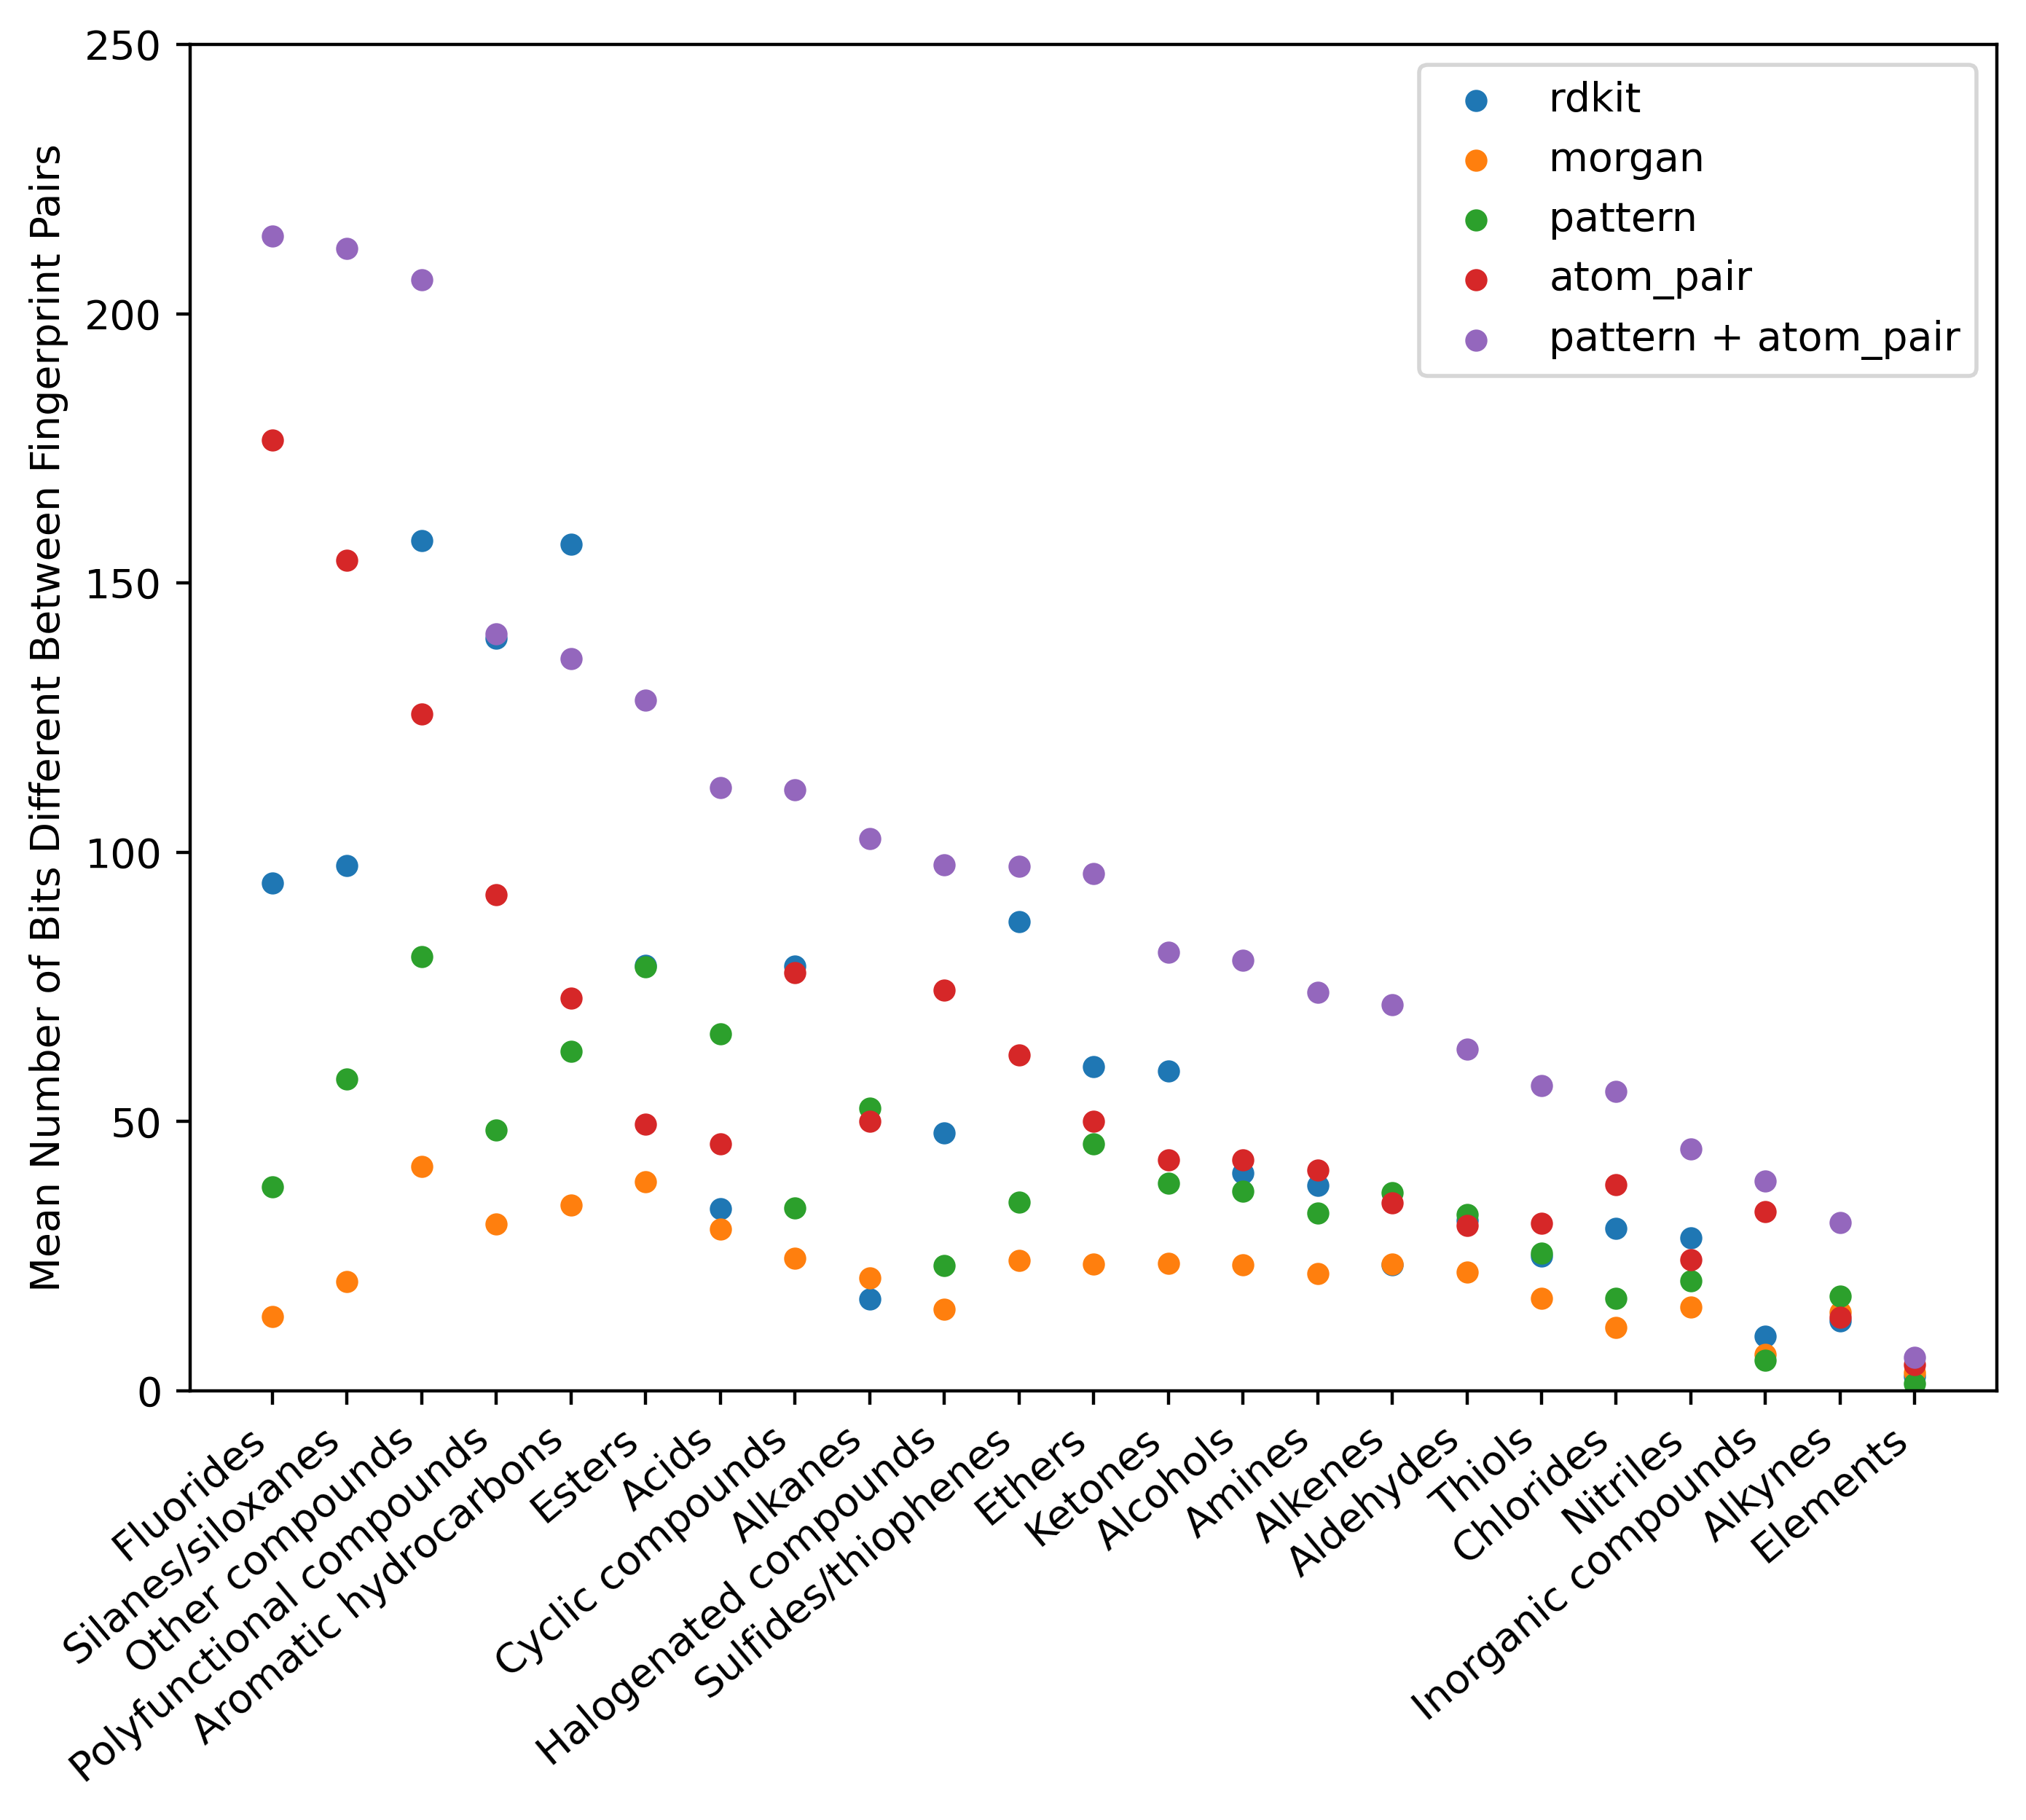

(0.0, 250.0)

In [ ]:
default_colours = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"] #, "#8c564b", "#e377c2",  "#7f7f7f", "#bcbd22", "#17becf"]

plt.figure(figsize=(8, 6), dpi=400)
for i = 1:length(means_all[1])
    plt.scatter(sorted_names,sorted_means_restructure[i],color = default_colours[i],s=20)
end

plt.ylabel("Mean Number of Bits Different Between Fingerprint Pairs")
plt.xticks(rotation=40,ha="right")
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "upper right")
plt.ylim([0,250])

In [10]:
unique_values = unique(processed_data[!, :family])
num_repeated_strings_all = []
means_diff_bits_over_fp_pairs_all = []
jaccard_coefficients_all = []
repeated_strings_all = []
fp_lengths_all = []

bits = 16384
radius = 5
num_fp = 31

rdkit = ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
morgan = ((mol) -> get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
atom_pair = ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
pattern = ((mol) -> get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
topological_torsion = ((mol) -> get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))

for j = 1:length(unique_values) + 1
    
    if j <= length(unique_values)
        println(unique_values[j])
        filtered_data_chem_family = filter(row -> row.family == unique_values[j], processed_data) ;
        filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
        isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]
    else
        println(j)
        filtered_data_chem_family = sort(processed_data, :Mw) 
        isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]
    end

    fps_r = []; fps_m = []; fps_ap = []; fps_p = []; fps_tt = []

    num_repeated_strings_per_family = []
    fp_lengths_per_family = []
    means_diff_bits_over_fp_pairs_per_family = []
    jaccard_coefficients_per_family = []
    repeated_strings_per_family = []

    all_fingerprint_combinatons = [[[0.0] for j = 1:(length(isomeric_smiles_family))] for i = 1:num_fp]

    for i = 1:length(isomeric_smiles_family)

        mol = get_mol(isomeric_smiles_family[i])

        base_fingerprints = []

        base_fingerprint_functions = [
            ((mol) -> rdkit(mol), fps_r),
            ((mol) -> morgan(mol), fps_m),
            ((mol) -> atom_pair(mol), fps_ap),
            ((mol) -> pattern(mol), fps_p),
            ((mol) -> topological_torsion(mol), fps_tt)]

            for (fingerprint_function, fingerprint_storage) in base_fingerprint_functions
                fp_str = fingerprint_function(mol)
                fingerprint_spec = [parse(Float64, string(c)) for c in fp_str]
                append!(base_fingerprints, [fingerprint_spec])
            end  

            r = base_fingerprints[1]
            m = base_fingerprints[2]
            ap = base_fingerprints[3]
            p = base_fingerprints[4]
            tt = base_fingerprints[5]

            fps_r = []; fps_m = []; fps_ap = []; fps_p = []; fps_tt = []
            fps_r_m = []; fps_r_p = []; fps_r_ap = []; fps_r_tt = []; fps_ap_m = []; fps_ap_p = []; fps_ap_tt = []; fps_tt_m = []; fps_tt_p = []; fps_m_p = [];
            fps_r_ap_tt = []; fps_r_ap_m = []; fps_r_ap_p = []; fps_r_tt_m = []; fps_r_tt_p = []; fps_r_m_p = []; fps_ap_tt_m = []; fps_ap_tt_p = []; fps_ap_m_p = []; fps_tt_m_p = []
            fps_r_ap_tt_m = []; fps_r_ap_tt_p = []; fps_r_ap_m_p = []; fps_r_tt_m_p = []; fps_ap_tt_m_p = [];
            fps_r_ap_tt_m_p = [];

            all_fingerprint_combinatons[1][i] = r # rdkit
            all_fingerprint_combinatons[2][i] = m # morgan
            all_fingerprint_combinatons[3][i] = ap # atom_pair
            all_fingerprint_combinatons[4][i] = p # pattern
            all_fingerprint_combinatons[5][i] = tt # topological torsion

            all_fingerprint_combinatons[6][i] = vcat(r, m) # rdkit, morgan
            all_fingerprint_combinatons[7][i] = vcat(r, p) # rdkit, pattern
            all_fingerprint_combinatons[8][i] = vcat(r, ap)
            all_fingerprint_combinatons[9][i] = vcat(r, tt)
            all_fingerprint_combinatons[10][i] = vcat(ap, m)
            all_fingerprint_combinatons[11][i] = vcat(ap, p)
            all_fingerprint_combinatons[12][i] = vcat(ap, tt)
            all_fingerprint_combinatons[13][i] = vcat(tt, m)
            all_fingerprint_combinatons[14][i] = vcat(tt, p)
            all_fingerprint_combinatons[15][i] = vcat(m, p)
            
            all_fingerprint_combinatons[16][i] = vcat(r, ap, tt)
            all_fingerprint_combinatons[17][i] = vcat(r, ap, m)
            all_fingerprint_combinatons[18][i] = vcat(r, ap, p)
            all_fingerprint_combinatons[19][i] = vcat(r, tt, m)
            all_fingerprint_combinatons[20][i] = vcat(r, tt, p)
            all_fingerprint_combinatons[21][i] = vcat(r, m, p)
            all_fingerprint_combinatons[22][i] = vcat(ap, tt, m)
            all_fingerprint_combinatons[23][i] = vcat(ap, tt, p)
            all_fingerprint_combinatons[24][i] = vcat(ap, m, p)
            all_fingerprint_combinatons[25][i] = vcat(tt, m, p)
            
            all_fingerprint_combinatons[26][i] = vcat(r, ap, tt, m)
            all_fingerprint_combinatons[27][i] = vcat(r, ap, tt, p)
            all_fingerprint_combinatons[28][i] = vcat(r, ap, m, p)
            all_fingerprint_combinatons[29][i] = vcat(r, tt, m, p)
            all_fingerprint_combinatons[30][i] = vcat(ap, tt, m, p)
            
            all_fingerprint_combinatons[31][i] = vcat(r, ap, tt, m, p)

            # if j < length(unique_values) + 1
            #     if unique_values[j] == "Thiols" || unique_values[j] == "Nitriles"
            #         println("$i: $(filtered_data_chem_family.common_name[i])")
            #     end
            # end
        
    end

    for fingerprints in all_fingerprint_combinatons
        # Remove repeated columns
            for num = [0, 1]
                num_cols = length(fingerprints[1])
                zero_cols = trues(num_cols)
                for vec in fingerprints
                    zero_cols .&= (vec .== num)
                end
                keep_cols = .!zero_cols # Create a Mask
                fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
            end
        
            # Fingerprint comparisons for a given chemical family
            repeated_vectors = count_repeated_vectors(fingerprints)
            number_repeated_strings = length(values(repeated_vectors))
        
            repeated_species = []
            
            for i in keys(repeated_vectors)
                # Use a list comprehension to find indices where the vector matches the target_key
                matching_indices = findall(vector -> vector == i, fingerprints)
                for i in  matching_indices
                    # println(processed_data[i,:common_name]) # comment this in to print the names of repeated species
                    push!(repeated_species,processed_data[i,:common_name])
                end
            end

            result_compare = compare_fingerprints(fingerprints)       

            push!(repeated_strings_per_family, repeated_species)
            push!(fp_lengths_per_family, length(fingerprints[1]))
            push!(num_repeated_strings_per_family, number_repeated_strings)
            push!(means_diff_bits_over_fp_pairs_per_family, result_compare[2])
            push!(jaccard_coefficients_per_family, result_compare[3])
            
    end

    push!(num_repeated_strings_all, num_repeated_strings_per_family)
    push!(means_diff_bits_over_fp_pairs_all, means_diff_bits_over_fp_pairs_per_family)
    push!(jaccard_coefficients_all, jaccard_coefficients_per_family)
    push!(repeated_strings_all, repeated_strings_per_family)
    push!(fp_lengths_all, fp_lengths_per_family)

    # @show repeated_strings_per_family
    @show num_repeated_strings_per_family
    # @show means_diff_bits_over_fp_pairs_per_family
    @show jaccard_coefficients_per_family

end


Acids
num_repeated_strings_per_family = Any[1, 1, 0, 1, 4, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
jaccard_coefficients_per_family = Any[0.7038343898779721, 0.7487214130465975, 0.6515658706198885, 0.6196012976486268, 0.759998652137281, 0.7235832202731716, 0.6561752873209855, 0.6664972415960145, 0.716420827516128, 0.684633327442723, 0.6365618120106348, 0.666649989460771, 0.7507120131965848, 0.6486591297902713, 0.6759585277980452, 0.6756550884724811, 0.6871611570489103, 0.6514544364842374, 0.728343535751013, 0.6690849965078589, 0.6832967128090014, 0.6917734039370295, 0.6480345938925923, 0.66354053903217, 0.6865064298357112, 0.6925605319303783, 0.659278069283386, 0.6700678854147617, 0.6901720563019181, 0.6704298664885294, 0.6753331313893646]
Alcohols
num_repeated_strings_per_family = Any[4, 1, 0, 6, 6, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
jaccard_coefficients_per_family = Any[0.8488736788301627, 0.8659897465214

In [48]:
fingerprint_data_read = CSV.read("../special_thingy_params/fingerprint_analysis_data_r6_b16384.csv", DataFrame, header=1);

In [49]:
num_rows = 24 #length(means_diff_bits_over_fp_pairs_all)
fingerprints = ["r", "m", "ap", "p", "tt", "r + m", "r + p", "r + ap", "r + tt", "ap + m", "ap + p",
                "ap + tt", "tt + m", "tt + p", "m + p", "r + ap + tt", "r + ap + m", "r + ap + p",
                "r + tt + m", "r + tt + p", "r + m + p", "ap + tt + m", "ap + tt + p", "ap + m + p",
                "tt + m + p", "r + ap + tt + m", "r + ap + tt + p", "r + ap + m + p", "r + tt + m + p",
                "ap + tt + m + p", "r + ap + tt + m + p"]

chemical_families = unique(processed_data[!, :family])
chemical_families_with_count = []

for i = 1:length(chemical_families) + 1

    if i <= length(chemical_families)
        num_species_per_family = nrow(filter(row -> row.family == chemical_families[i], processed_data))
        family = chemical_families[i]
        push!(chemical_families_with_count,"$family ($num_species_per_family)")
    else
        num_species_per_family = nrow(processed_data)
        family = "All Species"
        push!(chemical_families_with_count,"$family ($num_species_per_family)")
    end
end

fingerprint_analysis_data = DataFrame(
    Chemical_Family = fill("", num_rows),
    r = fill([0.0], num_rows),
    m = fill([0.0], num_rows),
    ap = fill([0.0], num_rows),
    p = fill([0.0], num_rows),
    tt = fill([0.0], num_rows),
    
    r_m = fill([0.0], num_rows),
    r_p = fill([0.0], num_rows),
    r_ap = fill([0.0], num_rows),
    r_tt = fill([0.0], num_rows),
    ap_m = fill([0.0], num_rows),
    ap_p = fill([0.0], num_rows),
    ap_tt = fill([0.0], num_rows),
    tt_m = fill([0.0], num_rows),
    tt_p = fill([0.0], num_rows),
    m_p = fill([0.0], num_rows),

    r_ap_tt = fill([0.0], num_rows),
    r_ap_m = fill([0.0], num_rows),
    r_ap_p = fill([0.0], num_rows),
    r_tt_m = fill([0.0], num_rows),
    r_tt_p = fill([0.0], num_rows),
    r_m_p = fill([0.0], num_rows),
    ap_tt_m = fill([0.0], num_rows),
    ap_tt_p = fill([0.0], num_rows),
    ap_m_p = fill([0.0], num_rows),
    tt_m_p = fill([0.0], num_rows),

    r_ap_tt_m = fill([0.0], num_rows),
    r_ap_tt_p = fill([0.0], num_rows),
    r_ap_m_p = fill([0.0], num_rows),
    r_tt_m_p = fill([0.0], num_rows),
    ap_tt_m_p = fill([0.0], num_rows),

    r_ap_tt_m_p = fill([0.0], num_rows),
) ;

# convert string31s in read dataframe into arrays of floats
for j = 2:ncol(fingerprint_data_read)
    for i = 1:nrow(fingerprint_data_read)

        brackets_removed = replace(fingerprint_data_read[i,j], r"[\[\]]" => "")
        numbers_array = parse.(Float64, split(brackets_removed, ", "))
        fingerprint_analysis_data[i,j] = numbers_array

    end
end

fingerprint_analysis_data.Chemical_Family[1:23] = chemical_families
fingerprint_analysis_data.Chemical_Family[end] = "All Species";

chemical_families_with_count;

In [13]:
# # Assign output fingerprint data to dataframe, structuring each chemical family + fingerprint combination as an array

# for i = 1:length(num_repeated_strings_all[1])
#     append_array = []

#     for j = 1:length(num_repeated_strings_all)
#         push!(append_array, [num_repeated_strings_all[j][i], round(jaccard_coefficients_all[j][i], digits=3), round(means_diff_bits_over_fp_pairs_all[j][i], digits=2), fp_lengths_all[j][i]])
#     end
#     fingerprint_analysis_data[!,1+i] = append_array
# end

# fingerprint_analysis_data
# CSV.write("fingerprint_analysis_data_r5_b16384.csv", fingerprint_analysis_data) ;

In [50]:
# create matrices and yticks for heat maps

data_jaccard = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;
data_repeats = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;
data_mean_different_bits = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;
data_fingerprint_lengths = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;

for i = 2:ncol(fingerprint_analysis_data)
    values_jaccard = []
    values_repeats = []
    values_means = []
    values_lengths = []

    for j = 1:nrow(fingerprint_analysis_data)
        value_repeats = fingerprint_analysis_data[j,i][1]
        value_jacccard = fingerprint_analysis_data[j,i][2]
        value_mean = fingerprint_analysis_data[j,i][3]
        value_length = fingerprint_analysis_data[j,i][4]

        push!(values_jaccard,value_jacccard)
        push!(values_repeats,value_repeats)
        push!(values_means,value_mean)
        push!(values_lengths,value_length)
    end
    data_jaccard[:,i-1] = values_jaccard
    data_repeats[:,i-1] = values_repeats
    data_mean_different_bits[:,i-1] = values_means
    data_fingerprint_lengths[:,i-1] = values_lengths

end

data_repeats_bounded = min.(data_repeats, 1);
data_repeats_bounded_NaN = replace(data_repeats, 0 => NaN)

min_value_jaccard = minimum(data_jaccard[.!isnan.(data_jaccard) .& (data_jaccard .!= 0)])
println(min_value_jaccard)


0.518


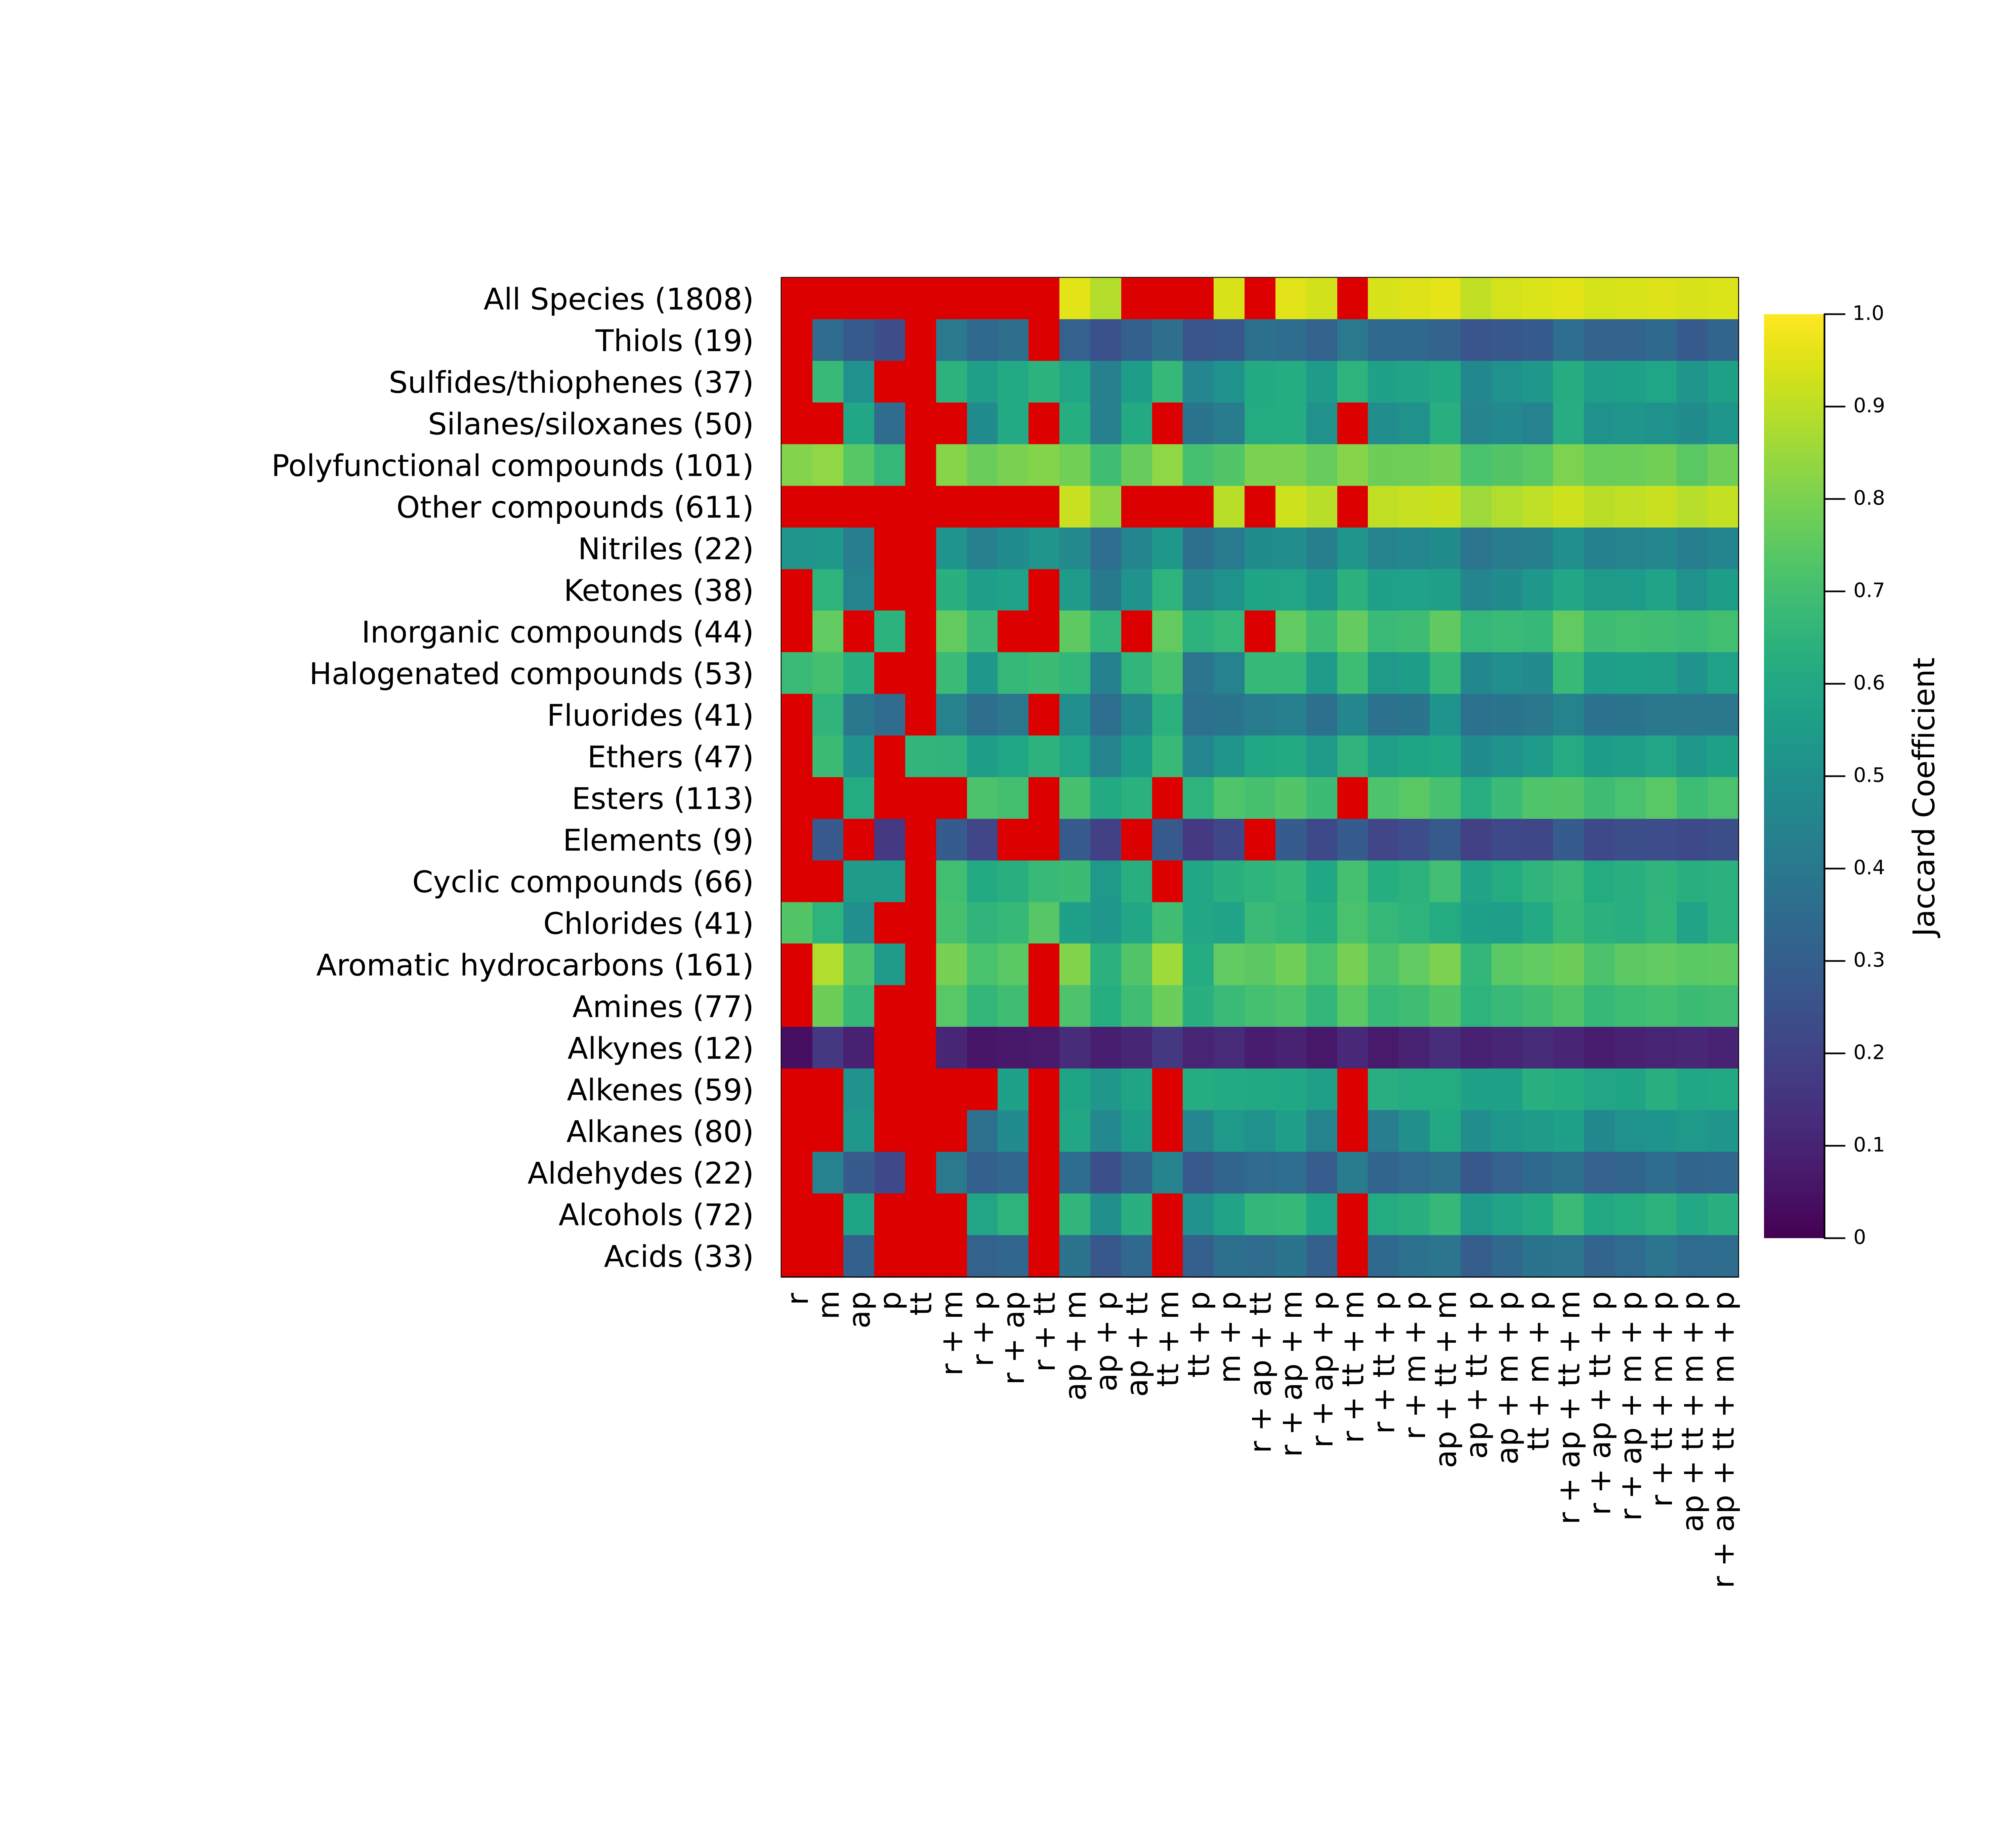

In [51]:
using Plots, Plots.PlotMeasures
gr()

custom_map = cgrad([RGBA(220/255,0,0,0), RGBA(220/255,0,0,1)])
clims = (0,1)

# Without colorbar
# size_fig = (800,675)
# heatmap(data_jaccard, c=:viridis, dpi=500, clim = (0.5,1),framestyle=:box, aspect_ratio=:auto, size=size_fig,xrotation = 90,margin = 0Plots.cm)
# heatmap!(data_repeats_bounded, c=custom_map, dpi=500, clim = (0.5,1),framestyle=:box, aspect_ratio=:auto, size=size_fig, colorbar=false,xrotation = 90,bottom_margin = [5mm 0mm],fontsize=30,xtickfont=font(12),ytickfont=font(12))

# yticks!(1:length(string.(chemical_families_with_count)), string.(chemical_families_with_count))
# xticks!((1:length(fingerprints)), fingerprints)

# With colorbar
size_fig = (1200,1100)
heatmap(data_jaccard, c=:viridis, dpi=500, clim = (0.5,1),framestyle=:box, aspect_ratio=:auto, size=size_fig,xrotation = 90,margin = 4Plots.cm)
heatmap!(data_repeats_bounded, c=custom_map, dpi=500, clim = (0.5,1),framestyle=:box, aspect_ratio=:auto, size=size_fig, colorbar=false,xrotation = 90,fontsize=30,xtickfont=font(12),ytickfont=font(12))

yticks!(1:length(string.(chemical_families_with_count)), string.(chemical_families_with_count))
xticks!((1:length(fingerprints)), fingerprints)

p_all = scatter!([NaN], [NaN], zcolor=[NaN], clims=clims, label="", c=:viridis, background_color_subplot=:transparent, markerstrokecolor=:transparent, framestyle=:none, inset=bbox(0.045, -0.08, 0.7, 0.5, :center, :right), subplot=2)

annotate!([(37.5, 12, text("Jaccard Coefficient", 12, :DejaVuSans, rotation=90))])

# savefig("fingerprint_images/Jaccard_Repeat_Overlay_b16384_r6.png");
# savefig("fingerprint_images/Jaccard_Repeat_Overlay_b16384_r6.svg");

In [123]:
using Plots, Plots.PlotMeasures

max_repeats = maximum(data_repeats_bounded_NaN[.!isnan.(data_repeats_bounded_NaN) .& (data_repeats_bounded_NaN .!= 0)])
max_different = maximum(data_mean_different_bits[.!isnan.(data_mean_different_bits) .& (data_mean_different_bits .!= 0)])
max_length = maximum(data_fingerprint_lengths[.!isnan.(data_fingerprint_lengths) .& (data_fingerprint_lengths .!= 0)])

@show max_repeats
@show max_different
@show max_length

# Create a 2x2 layout of subplots
plot_layout = plot(layout=(2, 2))

# Create heatmaps for each subplot
p1 = heatmap(data_jaccard, c=:viridis,clims=(0,1), framestyle=:box, aspect_ratio=:auto, xrotation=90, color=:viridis,right_margin = [15mm 0mm],bottom_margin = [15mm 0mm],colorbar_title="Jaccard Coefficient",grid=false)
p2 = heatmap(data_repeats_bounded_NaN, c=:viridis, clims=(0,100),framestyle=:box, aspect_ratio=:auto, xrotation=90,color=:viridis,right_margin = [15mm 0mm],bottom_margin = [15mm 0mm],colorbar_title="Num. Repeated Strings",grid=false)
p3 = heatmap(data_mean_different_bits, c=:viridis, clims=(0,500),framestyle=:box, aspect_ratio=:auto, xrotation=90,color=:viridis,right_margin = [15mm 0mm],bottom_margin = [15mm 0mm],colorbar_title="Mean Bits Different Between All Pairs",grid=false)
p4 = heatmap(data_fingerprint_lengths, c=:viridis, clims=(0,26000.0),framestyle=:box, aspect_ratio=:auto, xrotation=90,color=:viridis,right_margin = [15mm 0mm],bottom_margin = [15mm 0mm],colorbar_title="Fingerprint Length / Bits",grid=false)

# Show the plot
plot(p1,p2,p3,p4,layout = (2,2), size=(1600, 1100),xticks=(1:length(fingerprints), fingerprints),yticks=(1:length(string.(chemical_families_with_count)), string.(chemical_families_with_count)))

savefig("fingerprint_images/Fingerprint_Plot_2x2_Analysis_b16384_r6.png");
savefig("fingerprint_images/Fingerprint_Plot_2x2_Analysis_b16384_r6.svg");


max_repeats = 88.0
max_different = 455.6
max_length = 25408.0


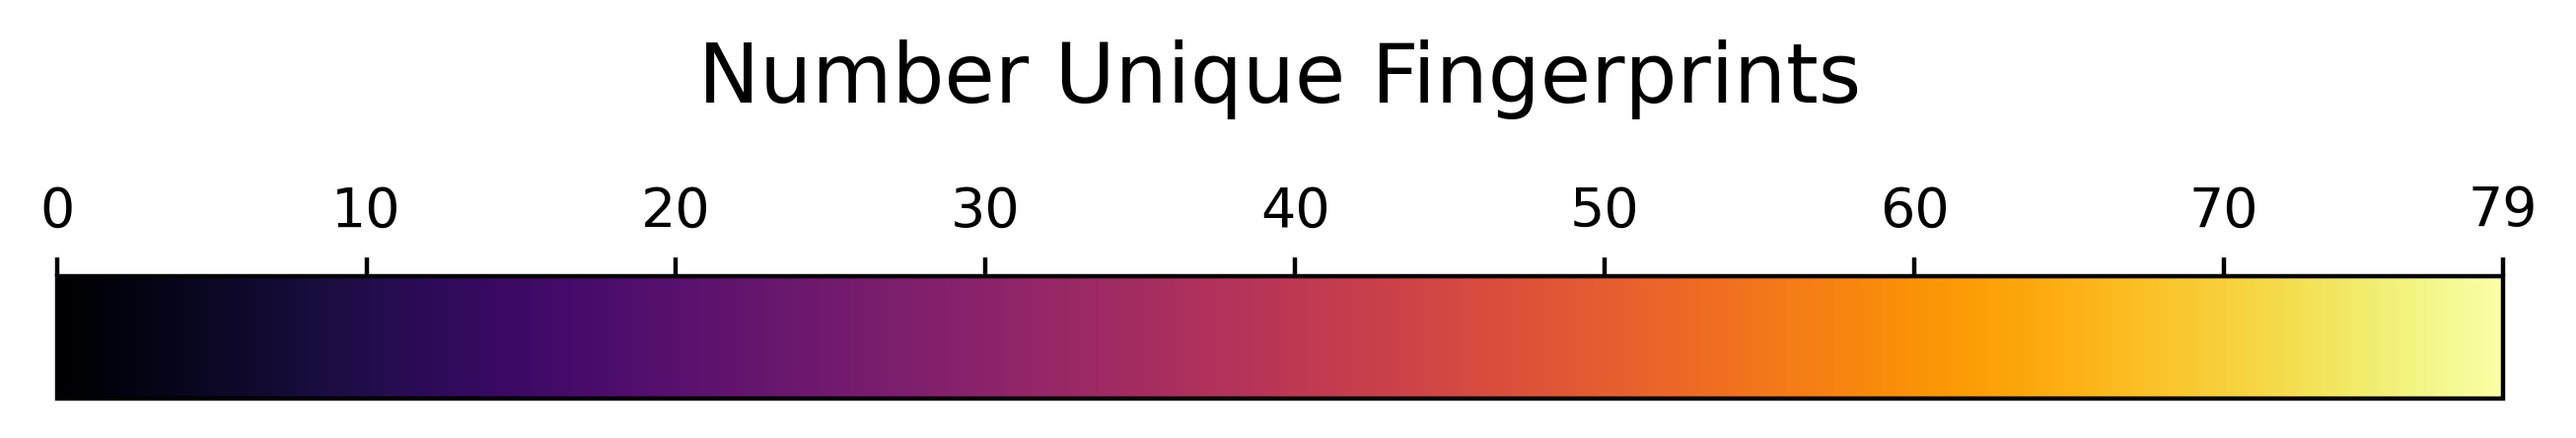

In [7]:
# Create a fake plot to generate a mappable object
fig, ax = plt.subplots(figsize=(8, 6), dpi=400)
mappable = ax.imshow([[0, 0], [0, 0]], cmap="inferno", vmin=0, vmax=79)

# Create a horizontal colorbar
cbar = plt.colorbar(mappable, orientation="horizontal", location="top")
cbar.set_label(label="Number Unique Fingerprints", size=15, labelpad=15)
cbar.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 79])

# Hide the axis and other elements
ax.axis("off")
ax.set_frame_on(false)
plt.delaxes(ax)

# Save the colorbar as SVG
# savefig("horizontal_colourbar_inferno.svg",)


In [7]:
filtered_data_chem_family = filter(row -> row.family == "Alkanes", processed_data) ;
filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

bits_range = [2 , 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 65536]
radii_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 200]

data_jaccard_all = []
data_repeats_all = []
data_repeats_bounded_all = []
data_uniques_all = []

for j = 1:6

    data_jaccard = zeros(Float64,length(bits_range),length(radii_range)) ;
    data_uniques = zeros(Float64,length(bits_range),length(radii_range)) ;

    num_repeated_strings_all = []
    means_diff_bits_over_fp_pairs_all = []
    jaccard_coefficients_all = []
    unique_strings_all = []
    fp_lengths_all = []

for k = 1:length(bits_range)

    bits = bits_range[k]

for L = 1:length(radii_range)

    radius = radii_range[L]

    rdkit = ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
    morgan = ((mol) -> get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
    atom_pair = ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
    pattern = ((mol) -> get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))
    topological_torsion = ((mol) -> get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nBits" => bits)))

    num_repeated_strings_per_family = []
    fp_lengths_per_family = []
    means_diff_bits_over_fp_pairs_per_family = []
    jaccard_coefficients_per_family = []
    repeated_strings_per_family = []

    fingerprints = []
    result_compare = []
    number_repeated_strings = []
    number_unique_strings = []

    try

    for i = 1:length(isomeric_smiles_family)

        mol = get_mol(isomeric_smiles_family[i])

        fps_r = []; fps_m = []; fps_ap = []; fps_p = []; fps_tt = []; fps_ap_p = [];

        base_fingerprint_functions = [
            ((mol) -> rdkit(mol), fps_r),
            ((mol) -> morgan(mol), fps_m),
            ((mol) -> atom_pair(mol), fps_ap),
            ((mol) -> pattern(mol), fps_p),
            ((mol) -> topological_torsion(mol), fps_tt)]

            if j < 6
                fingerprint_function, fingerprint_storage = base_fingerprint_functions[j]
                fp_str = fingerprint_function(mol)
            else
                fingerprint_function1, fingerprint_storage1 = base_fingerprint_functions[3]
                fingerprint_function2, fingerprint_storage2 = base_fingerprint_functions[4]
                fp_str = fingerprint_function1(mol) * fingerprint_function2(mol)
            end

            fingerprint_spec = [parse(Float64, string(c)) for c in fp_str]
            append!(fingerprints, [fingerprint_spec]) 
        
    end

    for num = [0, 1]
        num_cols = length(fingerprints[1])
        zero_cols = trues(num_cols)
        for vec in fingerprints
            zero_cols .&= (vec .== num)
        end
        keep_cols = .!zero_cols # Create a Mask
        fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
    end

    # println(fingerprints)

    # Fingerprint comparisons for a given chemical family
    repeated_vectors = count_repeated_vectors(fingerprints)
    number_repeated_strings = length(values(repeated_vectors))

    unique_vectors = count_unique_vectors(fingerprints)
    number_unique_strings = length(values(unique_vectors))

    # println(unique_vectors)
    # println(number_unique_strings)

    repeated_species = []
    
    for i in keys(repeated_vectors)
        # Use a list comprehension to find indices where the vector matches the target_key
        matching_indices = findall(vector -> vector == i, fingerprints)
        for i in  matching_indices
            # println(filtered_data_chem_family[i,:common_name]) # comment this in to print the names of repeated species
            push!(repeated_species,filtered_data_chem_family[i,:common_name])
        end
    end

    result_compare = compare_fingerprints(fingerprints)  

catch e

    result_compare = [NaN, NaN, NaN, NaN, NaN]
    number_unique_strings = NaN

end

    # println(number_unique_strings)
    
    data_jaccard[k,L] = result_compare[3]
    data_uniques[k,L] = number_unique_strings

    # println(data_uniques)

            
end

end

    # push!(num_repeated_strings_all, num_repeated_strings_per_family)
    # push!(means_diff_bits_over_fp_pairs_all, means_diff_bits_over_fp_pairs_per_family)
    # push!(jaccard_coefficients_all, jaccard_coefficients_per_family)
    # push!(repeated_strings_all, repeated_strings_per_family)
    # push!(fp_lengths_all, fp_lengths_per_family)

    # @show repeated_strings_per_family
    # @show num_repeated_strings_per_family
    # @show means_diff_bits_over_fp_pairs_per_family
    # @show jaccard_coefficients_per_family

    # data_repeats_bounded = min.(data_repeats, 1);

    push!(data_jaccard_all, data_jaccard)
    push!(data_uniques_all, data_uniques)

    # push!(data_repeats_bounded_all, replace(data_repeats_bounded, 0 => NaN))
end


In [8]:

data_uniques_all[2]
# data_uniques_bounded

15×12 Matrix{Float64}:
  3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0
  5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0
 27.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0
 41.0  50.0  55.0  55.0  59.0  60.0  60.0  60.0  60.0  61.0  62.0  62.0
 41.0  51.0  57.0  65.0  67.0  71.0  71.0  72.0  75.0  75.0  76.0  76.0
 46.0  52.0  57.0  67.0  69.0  72.0  73.0  75.0  77.0  77.0  79.0  79.0
 48.0  52.0  60.0  67.0  69.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  52.0  60.0  67.0  69.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  54.0  60.0  67.0  70.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  54.0  60.0  67.0  70.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  54.0  60.0  67.0  70.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  54.0  60.0  67.0  70.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  54.0  60.0  67.0  70.0  72.0  74.0  76.0  78.0  78.0  80.0  80.0
 48.0  54.0  60.0  67.0  70.0  72.0  74.0

80.0


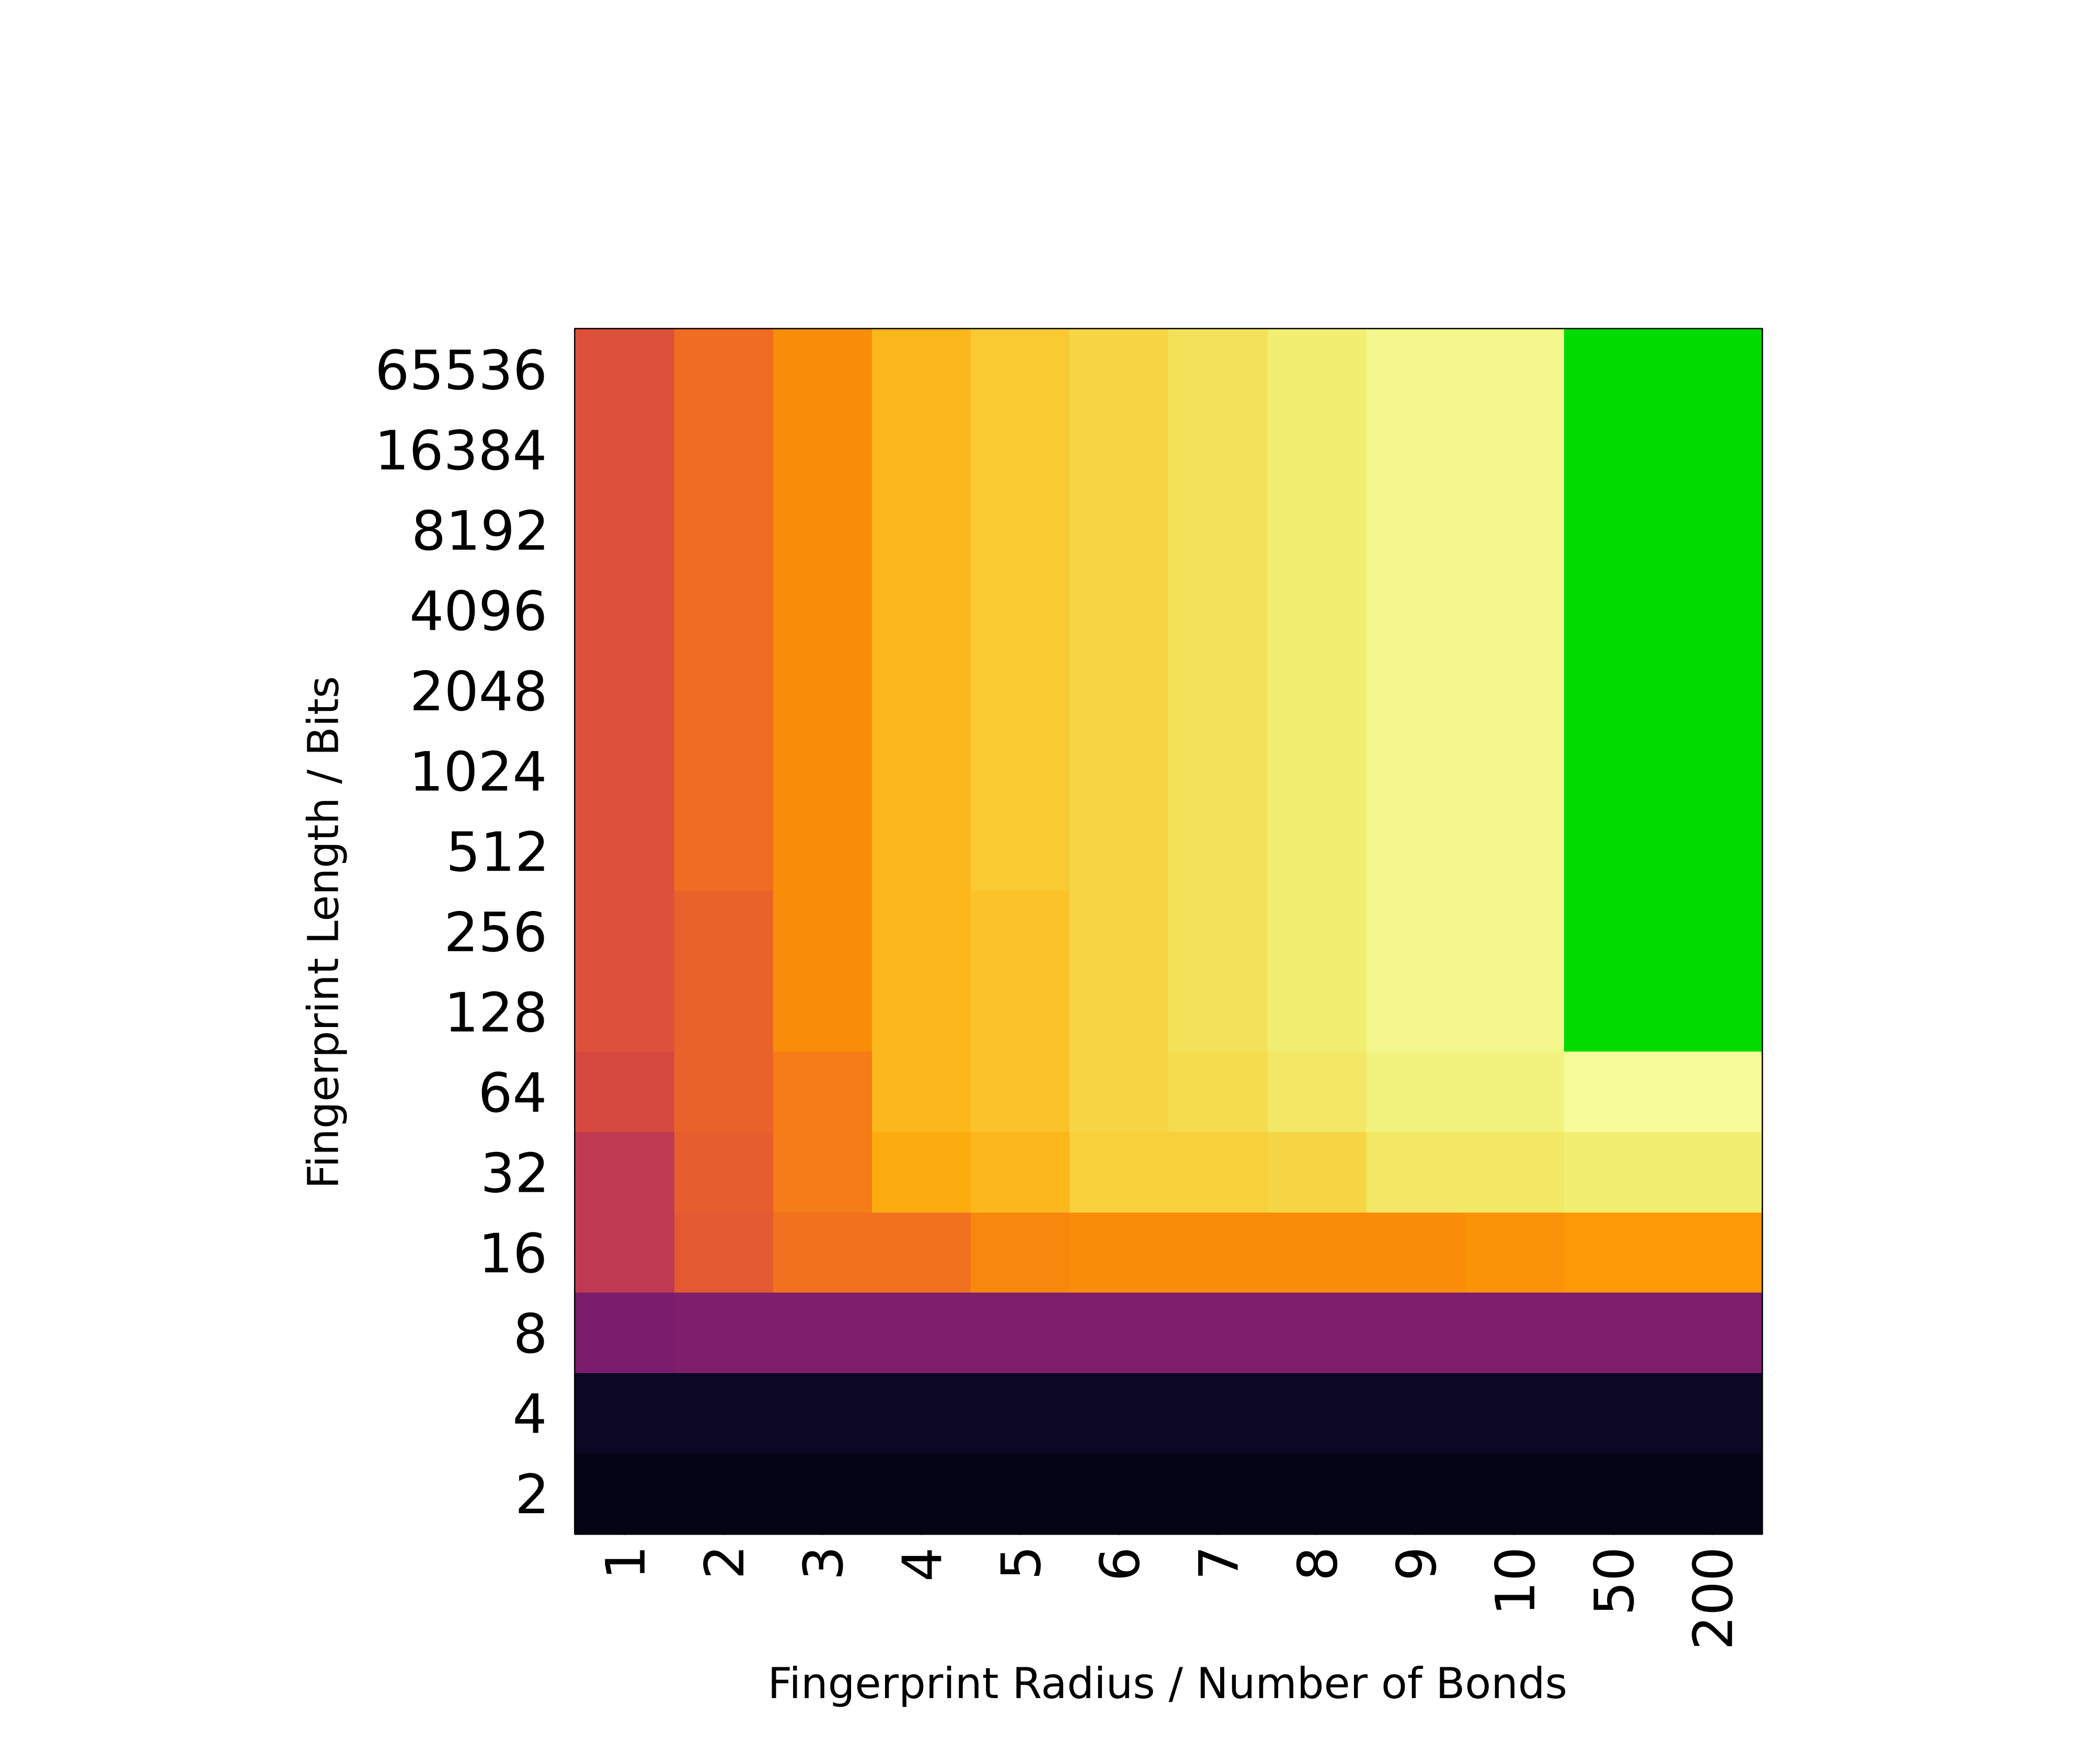

In [13]:
using Plots, Plots.PlotMeasures
gr()

fingerprint_index = 2

println(maximum(data_uniques_all[fingerprint_index]))

# data_uniques_bounded = min.(data_repeats_all[2], 1);
data_uniques_bounded = zeros(Float64,length(bits_range),length(radii_range))
data_uniques_bounded .= ifelse.(0 .<= data_uniques_all[fingerprint_index] .<= 79, NaN, data_uniques_all[fingerprint_index])

custom_map = cgrad([RGBA(0,220/255,0,0), RGBA(0,220/255,0,1)])
clims = (0,1)
size_fig = (800,675)

heatmap(data_uniques_all[fingerprint_index], c=:inferno, dpi=500, clim = (0,80),framestyle=:box, aspect_ratio=:auto, size=size_fig,xrotation = 90,margin = 3Plots.cm)
heatmap!(data_uniques_bounded, c=custom_map, dpi=500,framestyle=:box, aspect_ratio=:auto, clim = (0,80),size=size_fig, colorbar=false,xrotation = 90,bottom_margin = [5mm 0mm],fontsize=30,xtickfont=font(14),ytickfont=font(14))

yticks!(1:length(string.(bits_range)), string.(bits_range))
xticks!((1:length(string.(radii_range))), string.(radii_range))

xlabel!("Fingerprint Radius / Number of Bonds")
ylabel!("Fingerprint Length / Bits")
# title!("rdkit")
# display()

# savefig("morgan_fp_unique_vectors.svg")